In [2]:
import sys
import numpy as np
from wotan import flatten
from glob import glob
from time import time as _time
from pathlib import Path
from astropy.timeseries import BoxLeastSquares
from nuance import Nuance

points = [1000, 5000, 10000, 20000, 50000, 100000]

verbose = True
periods = np.linspace(0.1, 10, 5000)
times = {
    "biweight": [],
    "nuance_linear": [],
    "nuance_periodic": [],
    "bls": [],
}

# wotan 3D
# --------
for n in points:
    time = np.linspace(0, 3, n)
    flux = np.random.normal(1.0, 0.01, size=len(time))
    error = np.ones_like(time) * 0.0001

    # biweight
    # --------
    t0 = _time()
    flatten_trend = flatten(time, flux, window_length=0.01, return_trend=True)[1]
    flatten_flux = flux - flatten_trend
    flatten_flux -= np.mean(flatten_flux)
    flatten_flux += 1.0
    times["biweight"].append(_time() - t0)

    # BLS
    # ---
    t0 = _time()
    model = BoxLeastSquares(time, flux, dy=error)
    results = model.power(periods, 0.03)
    times["bls"].append(_time() - t0)

    # nuance
    # ------
    t0 = _time()
    nu = Nuance(time, flux, error)
    nu.linear_search(time, np.array([0.01, 0.02]))
    times["nuance_linear"].append(_time() - t0)
    t0 = _time()
    # search = nu.periodic_search(periods)
    # times["nuance_periodic"].append(_time() - t0)


extended_bls = []
points = [50000, 100000, 200000, 500000]
for n in points:
    time = np.linspace(0, 3, n)
    flux = np.random.normal(1.0, 0.01, size=len(time))
    error = np.ones_like(time) * 0.0001

    # BLS
    # ---
    model = BoxLeastSquares(time, flux, dy=error)
    results = model.power(periods, 0.03)
    extended_bls.append(_time() - t0)

100%|██████████| 100000/100000 [02:23<00:00, 698.84it/s]


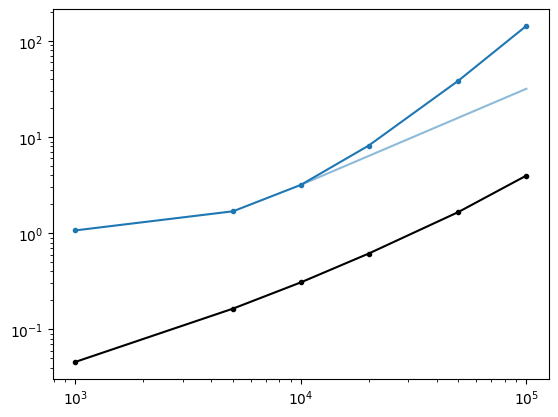

In [5]:
import matplotlib.pyplot as plt

nuance_lin = np.array(times["nuance_linear"])
plt.plot(points, nuance_lin, ".-", c="C0")
p = np.arange(10)
lin_10000 = (1 + p) * nuance_lin[2]
plt.plot((p + 1) * 10000, lin_10000, alpha=0.5)
plt.plot(points, times["bls"], ".-", c="k")
plt.yscale("log")
plt.xscale("log")

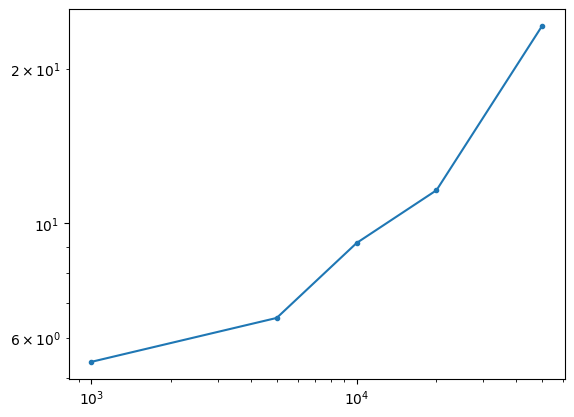

In [50]:
plt.plot(points, times["nuance_periodic"], ".-", c="C0")
plt.yscale("log")
plt.xscale("log")


In [30]:
p


array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009])

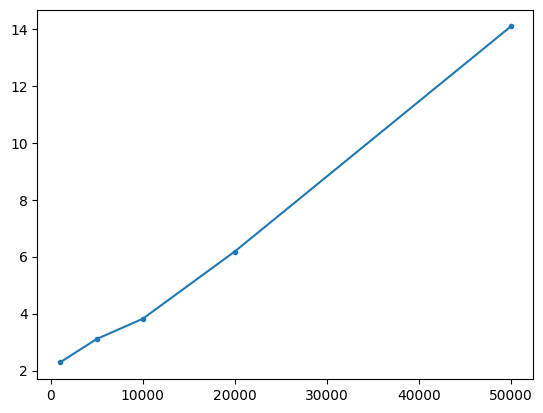

In [2]:
# sort the dict by keys
times2 = {int(name.split("_")[0]): times[name] for name in times.keys()}
times2 = {k: v for k, v in sorted(times2.items(), key=lambda item: item[0])}
import matplotlib.pyplot as plt

plt.plot(times2.keys(), times2.values(), ".-")

In [3]:
# save
np.save("../data/tls_times.npy", times2)


In [6]:
import sys

import numpy as np

sys.path.append("../lib")
import numpy as np
from tls import tls
from wotan import flatten
from glob import glob
from time import time as _time
from pathlib import Path

files = glob("../data/lightcurves/*_1.npy")

verbose = True
periods = np.linspace(0.1, 10, 5000)
times = {}
files = [
    "../data/lightcurves/1000_1.npy",
    "../data/lightcurves/5000_1.npy",
    "../data/lightcurves/10000_1.npy",
    "../data/lightcurves/20000_1.npy",
    "../data/lightcurves/50000_1.npy",
]
from nuance import Nuance

for f in files:
    f = Path(f)
    time, flux, error = np.load(f)
    t0 = _time()
    nu = Nuance(time, flux, error=error)
    t0s = time.copy()
    Ds = np.linspace(0.01, 0.1, 6)
    nu.linear_search(t0s, Ds)
    nu.periodic_search(periods)
    times[f.stem] = _time() - t0

100%|██████████| 5000/5000 [00:28<00:00, 173.05it/s]


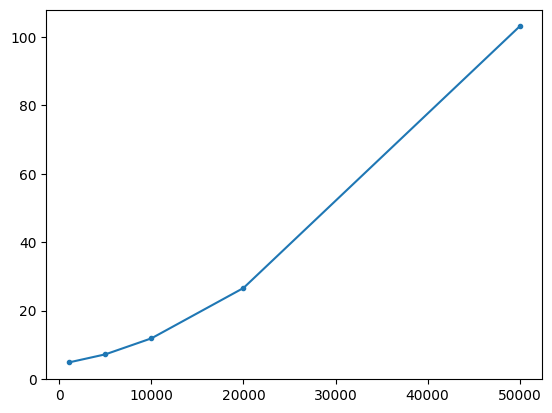

In [7]:
# sort the dict by keys
times2 = {int(name.split("_")[0]): times[name] for name in times.keys()}
times2 = {k: v for k, v in sorted(times2.items(), key=lambda item: item[0])}
import matplotlib.pyplot as plt

plt.plot(times2.keys(), times2.values(), ".-")

In [8]:
# save
np.save("../data/nuance_times.npy", times2)


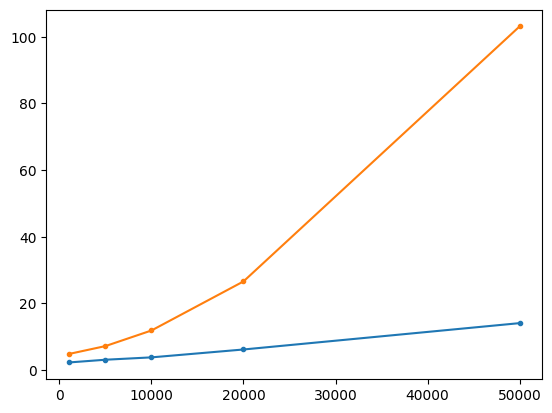

In [4]:
tls_times = np.load("../data/tls_times.npy", allow_pickle=True).item()
nuance_times = np.load("../data/nuance_times.npy", allow_pickle=True).item()

plt.plot(tls_times.keys(), tls_times.values(), ".-", label="TLS")
plt.plot(nuance_times.keys(), nuance_times.values(), ".-", label="Nuance")
